In [1]:
import pandas as pd
import string
import re
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk

# Ensure necessary NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jacobemerson/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jacobemerson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jacobemerson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jacobemerson/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
jobs_df = pd.read_csv("/Users/jacobemerson/code/cgallin/cover_genie/raw_data/job_data/postings.csv")
jobs_df.head(5)

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,NaN,1.713452e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,70000.0,52601.0,19057.0


In [3]:
# def preprocessor(df):
#     def text_cleaner(df):
#         # Ensure 'description' column exists
#         if 'description' not in df.columns:
#             raise ValueError("DataFrame must contain a 'description' column.")
        
#         # Drop rows with missing 'description' values
#         df_cleaned = df.dropna(subset=['description'])
        
#         # Convert text to lowercase and remove punctuation
#         translator = str.maketrans('', '', string.punctuation)
#         df_cleaned['description'] = df_cleaned['description'].str.lower().str.translate(translator)
        
#         # Remove numbers
#         df_cleaned['description'] = df_cleaned['description'].str.replace(r'\d+', '', regex=True)
        
#         return df_cleaned['description']

#     text = text_cleaner(df)

#     # Tokenize the text
#     def tokenizer(texts):
#         return texts.apply(word_tokenize)

#     tokens = tokenizer(text)

#     # Remove stopwords
#     def remove_stopwords(tokens):
#         stop_words = set(stopwords.words('english')).union(stopwords.words('french'))
#         return tokens.apply(lambda words: [w for w in words if w not in stop_words])

#     no_stopword_tokens = remove_stopwords(tokens)

#     # Lemmatize text
#     def lemmatize(tokens):
#         lemmatizer = WordNetLemmatizer()
        
#         def lemmatize_words(words):
#             # Lemmatize verbs and nouns
#             lemmatized_verbs = [lemmatizer.lemmatize(word, pos='v') for word in words]
#             lemmatized_nouns = [lemmatizer.lemmatize(word, pos='n') for word in lemmatized_verbs]
#             return lemmatized_nouns
        
#         return tokens.apply(lemmatize_words)

#     lemmatized_tokens = lemmatize(no_stopword_tokens)

#     # Return lemmatized tokens as a new DataFrame column
#     df['processed_description'] = lemmatized_tokens
#     return pd.DataFrame(df['processed_description'])
    


In [4]:
def preprocessor(df):
    # Clean and preprocess text
    def text_cleaner(df):
        if 'description' not in df.columns:
            raise ValueError("DataFrame must contain a 'description' column.")
        
        # Drop rows with missing descriptions
        df_cleaned = df.dropna(subset=['description']).copy()
        
        # Apply regex to clean text (keep only letters, replace others with space)
        df_cleaned['description'] = df_cleaned['description'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))
        
        # Convert to lowercase
        df_cleaned['description'] = df_cleaned['description'].str.lower()
        
        return df_cleaned['description']

    # Process sentences within the cleaned text
    def process_sentences(texts):
        # Set up stopwords and lemmatizer
        stop_words = set(stopwords.words('english')).union(stopwords.words('french'))
        lemmatizer = WordNetLemmatizer()
        
        # Extract features from sentences
        def extract_features(text):
            features = {'feature': ""}
            sentences = sent_tokenize(text)
            for sent in sentences:
                # Tokenize, remove stopwords, and filter by POS tags
                words = word_tokenize(sent)
                words = [word for word in words if word not in stop_words]
                tagged_words = pos_tag(words)
                filtered_words = [word for word, tag in tagged_words if tag not in ['DT', 'IN', 'TO', 'PRP', 'WP']]
                
                # Lemmatize remaining words
                lemmatized_words = [lemmatizer.lemmatize(word, pos='v') for word in filtered_words]
                lemmatized_words = [lemmatizer.lemmatize(word, pos='n') for word in lemmatized_words]
                
                # Append to features
                features['feature'] += " ".join(lemmatized_words) + " "
            return features['feature']
        
        # Apply feature extraction to all texts
        return texts.apply(extract_features)
    
    # Apply text cleaning
    cleaned_text = text_cleaner(df)
    
    # Process sentences and extract features
    processed_text = process_sentences(cleaned_text)
    
    # Add processed text as a new column
    df['processed_description'] = processed_text
    return df[['processed_description']].copy()

In [5]:
job_desc_words = preprocessor(jobs_df[0:100])

/var/folders/34/6f_0fz3s055bpk99ysxrnnth0000gn/T/ipykernel_4357/2823555327.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processed_description'] = processed_text


In [6]:
job_desc_words

,processed_description
0,job descriptiona lead real estate firm new jer...
1,aspen therapy wellness commit serve client bes...
2,national exemplar accept application assistant...
3,senior associate attorney elder law trust esta...
4,look hvac service tech experience commerical i...
...,...
95,qualificationsexperience data entry year requi...
96,firm dynamic srg boutique political consult fi...
97,global sculpt streetwear fashion brand naked w...
98,executive clean service inc maid service offer...


In [7]:
resumes_df = pd.read_csv('/Users/jacobemerson/code/cgallin/cover_genie/raw_data/archive-3/Resume/Resume.csv')
resumes_df.head(5)

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [8]:
resumes_df = resumes_df.rename(columns={'Resume_str':'description'})

In [9]:
resume_words = preprocessor(resumes_df[0:100])

/var/folders/34/6f_0fz3s055bpk99ysxrnnth0000gn/T/ipykernel_4357/2823555327.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['processed_description'] = processed_text


In [10]:
resume_words['processed_description'][0]

'hr administrator market associate hr administrator summary dedicate customer service manager year experience hospitality customer service management respect builder leader customer focus team strive instill share enthusiastic commitment customer service highlight focus customer satisfaction team management market savvy conflict resolution technique train development skilled multi tasker client relation specialist accomplishment missouri dot supervisor train certification certify ihg customer loyalty market segment hilton general manager train certification accomplish trainer cross server hospitality system hilton onq micros opera pm fidelio opera reservation system or holidex complete course seminar customer service sale strategy inventory control loss prevention safety time management leadership performance assessment experience hr administrator market associate hr administrator dec current company name city state help develop policy direct coordinate activity employment compensation

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine all text data for fitting the vectorizer
resumes = resume_words['processed_description'].str.split().sum()
job_desc = job_desc_words['processed_description'].str.split().sum()



In [12]:
len(resumes)

63517

In [13]:
len(job_desc)

24810

In [14]:
# Vectorizing the text data
vectorizer = TfidfVectorizer()
job_desc_tfidf = vectorizer.fit_transform(job_desc_words['processed_description'])
resume_tfidf = vectorizer.transform(resume_words['processed_description'])

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

tfidf_similarity_matrix = cosine_similarity(job_desc_tfidf, resume_tfidf)

In [40]:
# Define the number of top jobs to review
k = 5

for resume_idx in range(tfidf_similarity_matrix.shape[1]):  # Loop over resumes
    top_jobs = tfidf_similarity_matrix[:, resume_idx].argsort()[::-1][:k]
    print(f"Resume {resume_idx}: Top {k} jobs")
    for job_idx in top_jobs:
        similarity_score = tfidf_similarity_matrix[job_idx, resume_idx]
        print(f"  Job {job_idx}, Similarity: {similarity_score:.4f}")

Resume 0: Top 5 jobs
  Job 99, Similarity: 0.2606
  Job 35, Similarity: 0.2411
  Job 95, Similarity: 0.2365
  Job 14, Similarity: 0.2278
  Job 30, Similarity: 0.2236
Resume 1: Top 5 jobs
  Job 99, Similarity: 0.3563
  Job 35, Similarity: 0.3056
  Job 51, Similarity: 0.2930
  Job 14, Similarity: 0.2845
  Job 0, Similarity: 0.2809
Resume 2: Top 5 jobs
  Job 58, Similarity: 0.2764
  Job 30, Similarity: 0.2666
  Job 16, Similarity: 0.2548
  Job 89, Similarity: 0.2470
  Job 84, Similarity: 0.2054
Resume 3: Top 5 jobs
  Job 95, Similarity: 0.2345
  Job 81, Similarity: 0.2204
  Job 16, Similarity: 0.1880
  Job 10, Similarity: 0.1824
  Job 30, Similarity: 0.1727
Resume 4: Top 5 jobs
  Job 58, Similarity: 0.3069
  Job 30, Similarity: 0.2988
  Job 16, Similarity: 0.2755
  Job 57, Similarity: 0.2162
  Job 94, Similarity: 0.1861
Resume 5: Top 5 jobs
  Job 58, Similarity: 0.2896
  Job 30, Similarity: 0.2568
  Job 92, Similarity: 0.2473
  Job 81, Similarity: 0.2384
  Job 16, Similarity: 0.2048
Resum

In [38]:
print(resumes_df['description'][90])

         HR SHARED SERVICES ANALYST           Summary    Versatile HR professional with a strong benefits administration background, progressive cross-functional experience in broad range of HR functions including; HRIS, state and federal reporting, project management, client and vendor relation management, HR regulations, employee relations, HR policies and procedures, training, candidate screening and interviewing, employee oversight      Highlights        Applaud, Colleague, SAP, ADP, PeopleSoft, Microsoft Office, Aon/Hewitt HRIS Systems              Experience      HR Shared Services Analyst    September 2015   to   Current     Company Name   －   City  ,   State      Provide customer support for HRIS questions and issues by researching resolving simple to complex policy and transactional questions related to the use of the PeopleSoft HRIS and HR administrative policies and practices.  Assist in addressing and resolving inquiries from employees, managers and/or or internal HRBPs Pro

In [36]:
print(jobs_df.iloc[57]['description'])


# jobs_df

Job Posting: Service and Training DirectorCompany: Fine Dining Restaurant Group in New YorkPosition: Service and Training DirectorLocation: New York, NY (Multiple Locations)Salary Range: $120,000 - $140,000 per year
About Us:We are a distinguished fine dining restaurant group based in New York, committed to delivering exceptional culinary experiences and impeccable service to our guests. With multiple locations across the city, we take pride in our commitment to excellence, innovation, and providing a memorable dining experience for every patron.
Job Description:We are seeking a dynamic and experienced Service and Training Director to join our team. In this role, you will oversee the service operations and training programs across all our locations. You will be responsible for maintaining our high standards of service excellence, ensuring consistency, and implementing training initiatives to continuously elevate our staff's performance.Responsibilities:Develop and implement service sta

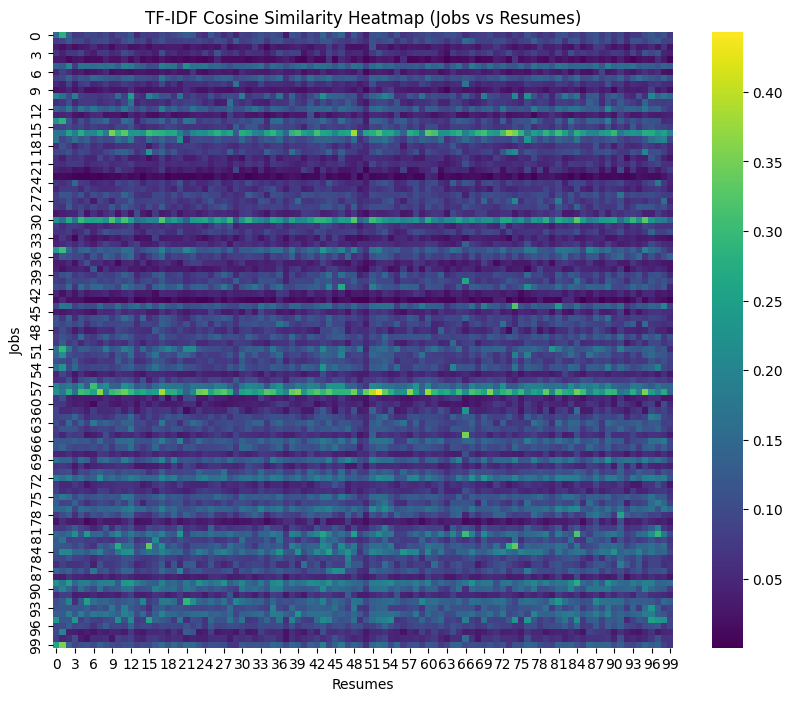

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(tfidf_similarity_matrix, cmap='viridis', annot=False)
plt.title("TF-IDF Cosine Similarity Heatmap (Jobs vs Resumes)")
plt.xlabel("Resumes")
plt.ylabel("Jobs")
plt.show()

In [18]:
jobs_df["description"][1]

'At Aspen Therapy and Wellness , we are committed to serving clients with best practices to help them with change, improvements and better quality of life. We believe in providing a secure, supportive environment to grow as a clinician and learn how to foster longevity in the career which is part of our mission statement.\nThank you for taking the time to explore a career with us. We are excited to be a new group practice in the community. If you are looking for quality supervision as you work towards licensure and ability to serve populations while accepting a variety of insurance panels, we may be a good fit. Our supervisors are trained in EMDR and utilize a parts work perspective with a trauma lens.\nWe are actively looking to hire a therapist in the area who is passionate about working with adults and committed to growth and excellence in the field. We are located in Old Town Square, Fort Collins.\nWe value and are strengthened by diversity and desire a warm and welcoming place for